In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
bit_data=pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date


In [56]:
group=bit_data.groupby("date")
data=group["Close"].mean()
# data=group[["Open", "High", "Low", "Close"]].mean()
# Using minute-data and the whole dataset takes ages to load
# bit_data["Close"] = bit_data["Close"].fillna(method="ffill")
# data = bit_data["Close"]

In [25]:
data.shape

(3376, 4)

In [7]:
data.isnull().sum()


0

In [26]:
data.head()

,Open,High,Low,Close
date,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500
2012-01-01,4.806667,4.806667,4.806667,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333


In [57]:
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

In [60]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
# close_train=close_train.reshape(close_train.shape[0],close_train.shape[1])
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

In [62]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,:])
    y_train.append(close_scaled[i,:])

x_train,y_train=np.array(x_train),np.array(y_train)
# x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (3276, 50, 1)
y_train shape=  (3276, 1)


In [12]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
52/52 [==============================] - 42s 589ms/step - loss: 0.0030
Epoch 2/100
52/52 [==============================] - 31s 603ms/step - loss: 0.0010
Epoch 3/100
52/52 [==============================] - 32s 617ms/step - loss: 9.5654e-04
Epoch 4/100
52/52 [==============================] - 33s 638ms/step - loss: 6.6511e-04
Epoch 5/100
52/52 [==============================] - 32s 621ms/step - loss: 6.3525e-04
Epoch 6/100
52/52 [==============================] - 28s 537ms/step - loss: 4.8631e-04
Epoch 7/100
52/52 [==============================] - 35s 681ms/step - loss: 7.4495e-04
Epoch 8/100
52/52 [==============================] - 31s 586ms/step - loss: 6.7515e-04
Epoch 9/100
52/52 [==============================] - 32s 623ms/step - loss: 4.4392e-04
Epoch 10/100
52/52 [==============================] - 33s 643ms/step - loss: 5.9196e-04
Epoch 11/100
52/52 [==============================] - 34s 650ms/step - loss: 4.6905e-04
Epoch 12/100
52/52 [=============================

In [63]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [64]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,:])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [15]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

2/2 [==============================] - 1s 63ms/step


In [16]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

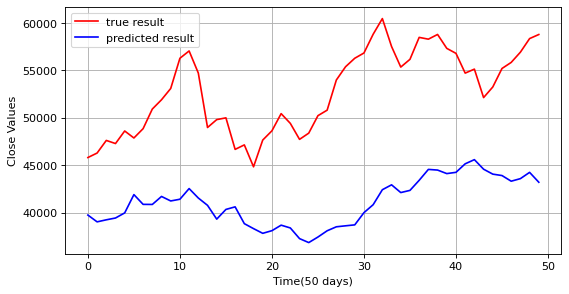

In [17]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [65]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))
# model.add(LSTM(10,input_shape=(None,4),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
103/103 [==============================] - 3s 17ms/step - loss: 0.0153
Epoch 2/100
103/103 [==============================] - 2s 19ms/step - loss: 0.0018
Epoch 3/100
103/103 [==============================] - 1s 14ms/step - loss: 5.8672e-04
Epoch 4/100
103/103 [==============================] - 2s 15ms/step - loss: 3.5964e-04
Epoch 5/100
103/103 [==============================] - 2s 15ms/step - loss: 3.2343e-04
Epoch 6/100
103/103 [==============================] - 1s 14ms/step - loss: 2.9523e-04
Epoch 7/100
103/103 [==============================] - 2s 15ms/step - loss: 2.8464e-04
Epoch 8/100
103/103 [==============================] - 2s 15ms/step - loss: 2.4823e-04
Epoch 9/100
103/103 [==============================] - 1s 14ms/step - loss: 2.5623e-04
Epoch 10/100
103/103 [==============================] - 1s 14ms/step - loss: 2.1660e-04
Epoch 11/100
103/103 [==============================] - 2s 22ms/step - loss: 2.0694e-04
Epoch 12/100
103/103 [===========================

In [66]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [67]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

2/2 [==============================] - 0s 2ms/step


In [68]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

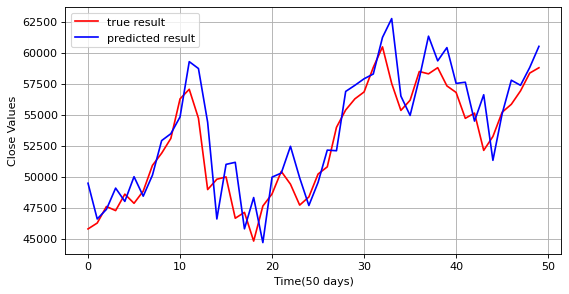

In [69]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()